Assingmet Details: 

Import the Liraries and files. I am going to do analysis with fllowing three files:- 

1) title.ratings.tsv
2) title.basics.tsv
3) title.crew.tsv
Goal is to do multi class classifiction for movies.

Assingment Details: 
The IMDB Dataset
Source: ​https://www.imdb.com/interfaces/
title.ratings.tsv.gz​ contains title id to rating mapping. However, the features are structured and not flattened in a vectorized form.
Part 1: Data Set Generation 15%
Join ​two ​other sources (e.g. title.crew.tsv.gz, title.basics.tsv.gz, etc) to make some meaningful features for rating prediction.
Part 2: Modeling 15%
Train/Dev/Test random split = 80/10/10
Model the problem as 3-class multiclass classification - split points are 3.3 and 6.6. The grade is given based on the accuracy:
>80%: 12 points
>85%: 13 points
>90%: 14 points
>95%: 15 points

IMDb Dataset Details

Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A ‘\N’ is used to denote that a particular field is missing or null for that title/name. The available datasets are as follows:

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
title_ratings =  pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", delimiter='\t', date_parser = 'python', keep_default_na = True, na_values = ['\\N'])
title_crew =  pd.read_csv("https://datasets.imdbws.com/title.crew.tsv.gz", delimiter='\t', date_parser = 'python', keep_default_na = True, na_values = ['\\N'])
title_basics =  pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", delimiter='\t', date_parser = 'python', keep_default_na = True, na_values = ['\\N'])

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


title.crew.tsv.gz – Contains the director and writer information for all the titles in IMDb. Fields include:
tconst (string) - alphanumeric unique identifier of the title
directors (array of nconsts) - director(s) of the given title
writers (array of nconsts) – writer(s) of the given title

Load the files into memeory for processing and cleanup before Modeling

In [3]:
nRow, nCol = title_ratings.shape
print(f'There are {nRow} rows and {nCol} columns')
print('\n')
print("Info: ", title_ratings.info())
print('\n')
print("Head:", title_ratings.columns)
print('\n')
print("Describe:", title_ratings.describe())
print('\n')
print("Unique", len(title_ratings.tconst.unique()))
print('\n')
print("Null Counts:", title_ratings.isna().sum())

There are 986685 rows and 3 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986685 entries, 0 to 986684
Data columns (total 3 columns):
tconst           986685 non-null object
averageRating    986685 non-null float64
numVotes         986685 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 22.6+ MB
Info:  None


Head: Index(['tconst', 'averageRating', 'numVotes'], dtype='object')


Describe:        averageRating      numVotes
count  986685.000000  9.866850e+05
mean        6.885898  9.575484e+02
std         1.401430  1.565718e+04
min         1.000000  5.000000e+00
25%         6.100000  9.000000e+00
50%         7.100000  2.000000e+01
75%         7.900000  7.600000e+01
max        10.000000  2.153177e+06


Unique 986685


Null Counts: tconst           0
averageRating    0
numVotes         0
dtype: int64


title.basics.tsv.gz - Contains the following information for titles:
tconst (string) - alphanumeric unique identifier of the title
titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
originalTitle (string) - original title, in the original language
isAdult (boolean) - 0: non-adult title; 1: adult title
startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
runtimeMinutes – primary runtime of the title, in minutes
genres (string array) – includes up to three genres associated with the title

In [4]:
nRow, nCol = title_basics.shape
print(f'There are {nRow} rows and {nCol} columns')
print('\n')
print("Info: ", title_basics.info())
print('\n')
print("Head:", title_basics.columns)
print('\n')
print("Describe:", title_basics.describe())
print('\n')
print("Unique", len(title_basics.tconst.unique()))
print('\n')
print("Null Counts:", title_basics.isna().sum())

There are 6272534 rows and 9 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272534 entries, 0 to 6272533
Data columns (total 9 columns):
tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           int64
startYear         float64
endYear           float64
runtimeMinutes    object
genres            object
dtypes: float64(2), int64(1), object(6)
memory usage: 430.7+ MB
Info:  None


Head: Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')


Describe:             isAdult     startYear       endYear
count  6.272534e+06  5.910482e+06  53891.000000
mean   3.299894e-02  2.001401e+03   2001.610325
std    2.546846e+00  2.121231e+01     18.910114
min    0.000000e+00  1.874000e+03     24.000000
25%    0.000000e+00  1.997000e+03   1993.000000
50%    0.000000e+00  2.009000e+03   2007.000000
75%    0.000000e+00  2.015000e+03  

The Two Columns:
endYear           5749014
runtimeMinutes    4049153
Has more than 50% as null values so we will drop these columns.

In [5]:
# More than 50% of datapoints have missing values for End year. So I am remving it for my considration.
# runtimeMinutes is having too much variance, if I consider it for my calculation, my laptop crashes. 
#I feel, this can be valuable value to consider
title_basics.drop(['endYear', 'runtimeMinutes'], axis=1, inplace = True)
title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272534 entries, 0 to 6272533
Data columns (total 7 columns):
tconst           object
titleType        object
primaryTitle     object
originalTitle    object
isAdult          int64
startYear        float64
genres           object
dtypes: float64(1), int64(1), object(5)
memory usage: 335.0+ MB


title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles
tconst (string) - alphanumeric unique identifier of the title
averageRating – weighted average of all the individual user ratings
numVotes - number of votes the title has received

In [6]:
nRow, nCol = title_crew.shape
print(f'There are {nRow} rows and {nCol} columns')
print('\n')
print("Info: ", title_crew.info())
print('\n')
print("Head:", title_crew.columns)
print('\n')
print("Describe:", title_crew.describe())
print('\n')
print("Unique", len(title_crew.tconst.unique()))
print('\n')
print("Null Counts:", title_crew.isna().sum())

There are 6272534 rows and 3 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272534 entries, 0 to 6272533
Data columns (total 3 columns):
tconst       object
directors    object
writers      object
dtypes: object(3)
memory usage: 143.6+ MB
Info:  None


Head: Index(['tconst', 'directors', 'writers'], dtype='object')


Describe:            tconst  directors    writers
count     6272534    3661455    3195482
unique    6272534     692125     980201
top     tt9833950  nm0565214  nm0417224
freq            1       5969       5424


Unique 6272534


Null Counts: tconst             0
directors    2611079
writers      3077052
dtype: int64


In [7]:
title_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


In [8]:
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,"Comedy,Short"


In [9]:
title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1545
1,tt0000002,6.1,187
2,tt0000003,6.5,1202
3,tt0000004,6.2,114
4,tt0000005,6.1,1924


In [10]:
print(title_crew['directors'].isna().sum())
title_crew.dropna(inplace = True)
print(title_crew['directors'].isna().sum())

2611079
0


In [11]:
import hashlib
title_crew['hashed_directors'] = title_crew['directors'].apply(lambda x: int(hashlib.sha1(x.encode()).hexdigest(), 16) % (100))

In [12]:
title_crew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2780711 entries, 8 to 6272533
Data columns (total 4 columns):
tconst              object
directors           object
writers             object
hashed_directors    int64
dtypes: int64(1), object(3)
memory usage: 106.1+ MB


In [13]:
#Do an Inner Join for first two datasets.
df_int = pd.merge(title_basics, title_ratings, on='tconst', how='inner')
print(df_int.info())
print(df_int.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986685 entries, 0 to 986684
Data columns (total 9 columns):
tconst           986685 non-null object
titleType        986685 non-null object
primaryTitle     986685 non-null object
originalTitle    986682 non-null object
isAdult          986685 non-null int64
startYear        986562 non-null float64
genres           965564 non-null object
averageRating    986685 non-null float64
numVotes         986685 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 75.3+ MB
None
(986685, 9)


In [14]:
#Merged the first dataset wth final one (third)
df = pd.merge(df_int, title_crew, on='tconst', how ='inner')
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722009 entries, 0 to 722008
Data columns (total 12 columns):
tconst              722009 non-null object
titleType           722009 non-null object
primaryTitle        722009 non-null object
originalTitle       722009 non-null object
isAdult             722009 non-null int64
startYear           721942 non-null float64
genres              709738 non-null object
averageRating       722009 non-null float64
numVotes            722009 non-null int64
directors           722009 non-null object
writers             722009 non-null object
hashed_directors    722009 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 71.6+ MB
None
(722009, 12)


In [15]:
# Count Nulls in Final Dataframe
print("Null Counts:", df.isna().sum())

Null Counts: tconst                  0
titleType               0
primaryTitle            0
originalTitle           0
isAdult                 0
startYear              67
genres              12271
averageRating           0
numVotes                0
directors               0
writers                 0
hashed_directors        0
dtype: int64


In [16]:
# New DataFrame Features
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
print('\n')
print("Info: ", df.info())
print('\n')
print("Head:", df.columns)
print('\n')
print("Describe:", df.describe())
print('\n')
print("Unique", len(df.tconst.unique()))
print('\n')
print("Null Counts:", df.isna().sum())

There are 722009 rows and 12 columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 722009 entries, 0 to 722008
Data columns (total 12 columns):
tconst              722009 non-null object
titleType           722009 non-null object
primaryTitle        722009 non-null object
originalTitle       722009 non-null object
isAdult             722009 non-null int64
startYear           721942 non-null float64
genres              709738 non-null object
averageRating       722009 non-null float64
numVotes            722009 non-null int64
directors           722009 non-null object
writers             722009 non-null object
hashed_directors    722009 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 71.6+ MB
Info:  None


Head: Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'genres', 'averageRating', 'numVotes', 'directors',
       'writers', 'hashed_directors'],
      dtype='object')


Describe:              isAdult      startYe

In [17]:
# originalTitle Has three NaN, so Forward Fill will be a good candidate to manage Nulls
df['originalTitle'].fillna(method='ffill')
# startYear Has quite a few NaN, so Mean of Values will be a good candidate to manage Nulls
df['startYear'].fillna(df['startYear'].mean())
# Three columns has many missing values, so dropping the missing values
#Director was a really good predictor, but I am dropping as it has too many unique values and I am not able to process it on my laptop.
df.dropna(subset=['genres', 'directors', 'writers', 'startYear'], inplace = True)

In [18]:
# New DataFrame Features
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
print('\n')
print("Info: ", df.info())
print('\n')
print("Head:", df.columns)
print('\n')
print("Describe:", df.describe())
print('\n')
print("Unique", len(df.tconst.unique()))
print('\n')
print("Null Counts:", df.isna().sum())

There are 709673 rows and 12 columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 709673 entries, 0 to 722008
Data columns (total 12 columns):
tconst              709673 non-null object
titleType           709673 non-null object
primaryTitle        709673 non-null object
originalTitle       709673 non-null object
isAdult             709673 non-null int64
startYear           709673 non-null float64
genres              709673 non-null object
averageRating       709673 non-null float64
numVotes            709673 non-null int64
directors           709673 non-null object
writers             709673 non-null object
hashed_directors    709673 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 70.4+ MB
Info:  None


Head: Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'genres', 'averageRating', 'numVotes', 'directors',
       'writers', 'hashed_directors'],
      dtype='object')


Describe:              isAdult      startYe

In [19]:
print("Unique directors", len(df.directors.unique()))
print("Unique writers", len(df.writers.unique()))

Unique directors 199752
Unique writers 397744


In [20]:
# Process Columns to Fix their Catogerical Values
df['titleType'] = df['titleType'].astype('category')
df['isAdult'] = df['isAdult'].astype('category')
df['genres'] = df['genres'].str.split(',')
df['directors'] = df['directors'].str.split(',')
df['writers'] = df['writers'].str.split(',')
df['startYear'] = df['startYear'].astype(int)

In [21]:
# New DataFrame Features
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
print('\n')
print("Info: ", df.info())
print('\n')
print("Head:", df.columns)
print('\n')
print("Describe:", df.describe())
print('\n')
print("Unique", len(df.tconst.unique()))
print('\n')
print("Null Counts:", df.isna().sum())

There are 709673 rows and 12 columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 709673 entries, 0 to 722008
Data columns (total 12 columns):
tconst              709673 non-null object
titleType           709673 non-null category
primaryTitle        709673 non-null object
originalTitle       709673 non-null object
isAdult             709673 non-null category
startYear           709673 non-null int64
genres              709673 non-null object
averageRating       709673 non-null float64
numVotes            709673 non-null int64
directors           709673 non-null object
writers             709673 non-null object
hashed_directors    709673 non-null int64
dtypes: category(2), float64(1), int64(3), object(6)
memory usage: 60.9+ MB
Info:  None


Head: Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'genres', 'averageRating', 'numVotes', 'directors',
       'writers', 'hashed_directors'],
      dtype='object')


Describe:            startY

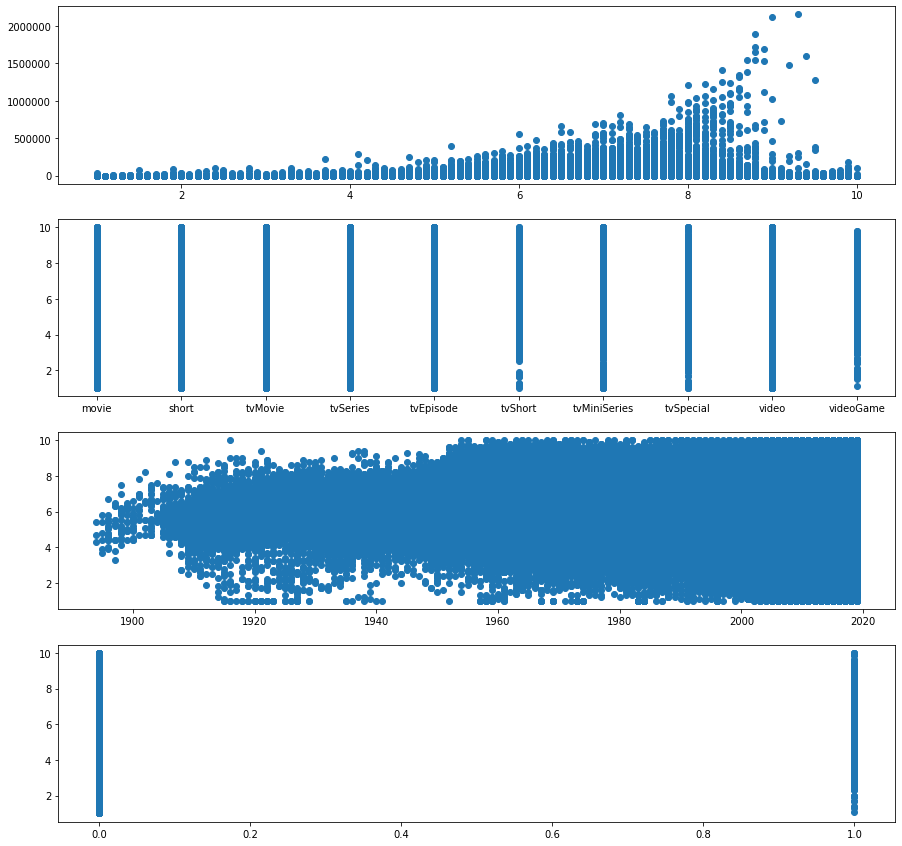

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(15,15))

plt.subplot(4, 1, 1)
plt.scatter(df['averageRating'], df['numVotes'])
plt.subplot(4, 1, 2)
plt.scatter(df['titleType'], df['averageRating'])
plt.subplot(4, 1, 3)
plt.scatter(df['startYear'], df['averageRating'])
plt.subplot(4, 1, 4)
plt.scatter(df['isAdult'], df['averageRating'])
plt.show()

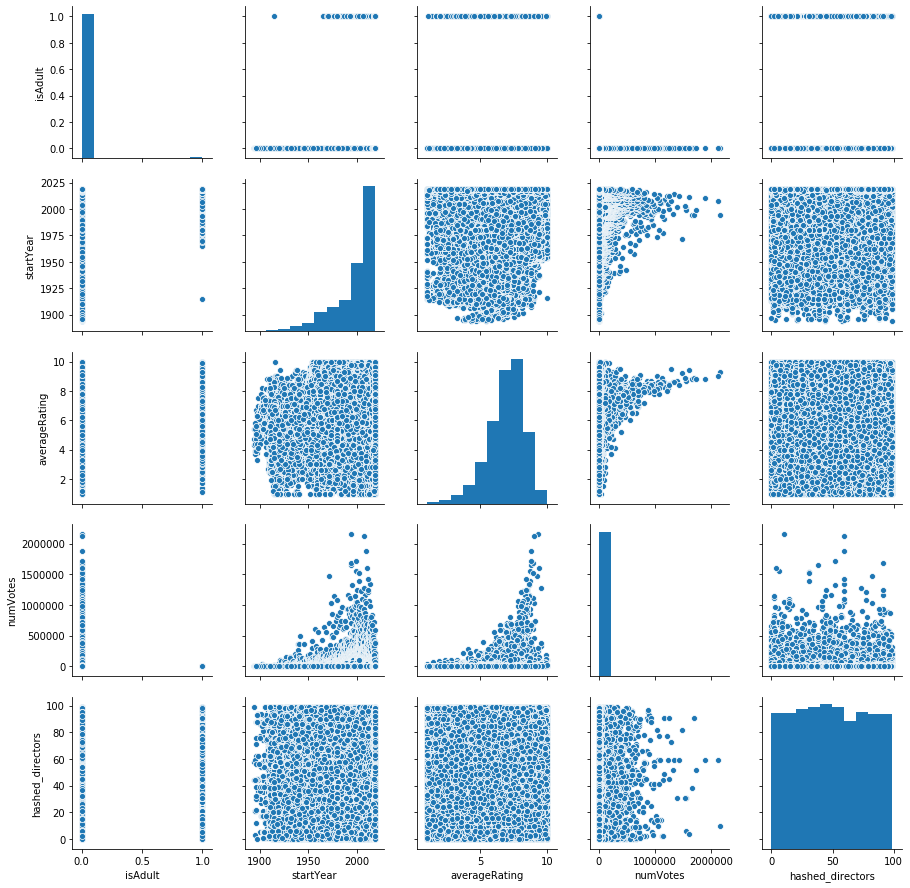

,startYear,averageRating,numVotes,hashed_directors
startYear,1,0.109077,0.0142374,0.000519816
averageRating,0.109077,1,0.0160281,-0.00501063
numVotes,0.0142374,0.0160281,1,-0.00142059
hashed_directors,0.000519816,-0.00501063,-0.00142059,1


In [23]:
# library for plots
import seaborn as sns
import matplotlib.pyplot as plt
 
# Basic correlogram
sns.pairplot(df)
plt.show()

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [24]:
def convrt_to_cat_val(num):
    x = ''
    if 0 <= num <= 3.3:
        x = 0
    elif 3.3 < num <= 6.6:
        x = 1
    elif 6.6 < num <= 10:
        x = 2
    return x

In [25]:
# Converting the Average Rating to Bins which are equally distributed. 
df['aRating_eq_bin'] = df['averageRating'].apply(lambda x: convrt_to_cat_val(x))
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres,averageRating,numVotes,directors,writers,hashed_directors,aRating_eq_bin
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,[Romance],5.4,81,[nm0085156],[nm0085156],99,1
1,tt0000036,short,Awakening of Rip,Awakening of Rip,0,1896,"[Drama, Short]",4.5,450,[nm0005690],[nm0410331],44,1
2,tt0000076,short,Exit of Rip and the Dwarf,Exit of Rip and the Dwarf,0,1896,"[Drama, Short]",4.5,393,[nm0005690],[nm0410331],44,1
3,tt0000091,short,The House of the Devil,Le manoir du diable,0,1896,"[Horror, Short]",6.7,2495,[nm0617588],[nm0617588],88,2
4,tt0000108,short,Rip Leaving Sleepy Hollow,Rip Leaving Sleepy Hollow,0,1896,"[Drama, Short]",4.4,405,[nm0005690],[nm0410331],44,1


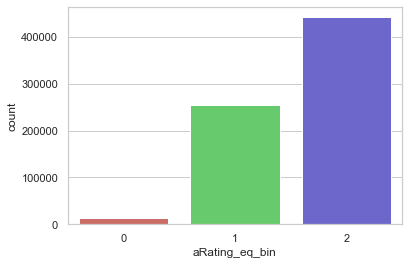

In [26]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#draw histogram plot
sns.countplot(df['aRating_eq_bin'], palette = 'hls')
plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709673 entries, 0 to 722008
Data columns (total 13 columns):
tconst              709673 non-null object
titleType           709673 non-null category
primaryTitle        709673 non-null object
originalTitle       709673 non-null object
isAdult             709673 non-null category
startYear           709673 non-null int64
genres              709673 non-null object
averageRating       709673 non-null float64
numVotes            709673 non-null int64
directors           709673 non-null object
writers             709673 non-null object
hashed_directors    709673 non-null int64
aRating_eq_bin      709673 non-null int64
dtypes: category(2), float64(1), int64(4), object(6)
memory usage: 86.3+ MB


In [28]:
#Use Quantiles to slipt the Averaging ratings so each bin is equally distributed
#Based on Discussion in class, we should not do equal eright classification.

#bin_labels = ['Low', 'Medium', 'High']
#df['aRating_qant_bin'] = pd.qcut(df.averageRating,3,labels=bin_labels)
#print(df.head())
#df.replace('\\N', np.NaN, inplace = True)
#print(df.head())
#print(df.info())

In [29]:
#import matplotlib.pyplot as plt 
#import seaborn as sns
#sns.set(style="white")
#sns.set(style="whitegrid", color_codes=True)
 
#draw histogram plot
#sns.countplot(df['aRating_qant_bin'], palette = 'hls')
#plt.show()

In [30]:
#df.count()

Drop Columns with no average Rating as we are going to predict Rating

In [31]:
#df2 = df[df['averageRating'].notnull()][['tconst','titleType', 'primaryTitle','originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'directors', 'writers', 'aRating_eq_bin', 'aRating_qant_bin']]
df2 = df[df['averageRating'].notnull()][['tconst','titleType', 'isAdult', 'startYear', 'genres', 'numVotes', 'directors', 'writers', 'aRating_eq_bin', 'averageRating']]
print(df2.count())

tconst            709673
titleType         709673
isAdult           709673
startYear         709673
genres            709673
numVotes          709673
directors         709673
writers           709673
aRating_eq_bin    709673
averageRating     709673
dtype: int64


In [32]:
print(df2.genres)

0                              [Romance]
1                         [Drama, Short]
2                         [Drama, Short]
3                        [Horror, Short]
4                         [Drama, Short]
                       ...              
722004                           [Drama]
722005                           [Drama]
722006       [Adventure, Comedy, Family]
722007                    [Drama, Short]
722008    [Adventure, Biography, Comedy]
Name: genres, Length: 709673, dtype: object


In [33]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709673 entries, 0 to 722008
Data columns (total 10 columns):
tconst            709673 non-null object
titleType         709673 non-null category
isAdult           709673 non-null category
startYear         709673 non-null int64
genres            709673 non-null object
numVotes          709673 non-null int64
directors         709673 non-null object
writers           709673 non-null object
aRating_eq_bin    709673 non-null int64
averageRating     709673 non-null float64
dtypes: category(2), float64(1), int64(3), object(4)
memory usage: 50.1+ MB
None


In [34]:
df2.agg(['nunique','count','size'])
# We have too many Primary Titles and Original Title. I feel they won't be of much help for my analysis.
# so I am dropping off them form dataset.

,tconst,titleType,isAdult,startYear,genres,numVotes,directors,writers,aRating_eq_bin,averageRating
nunique,709673,10,2,126,NaN,17175,NaN,NaN,3,91
count,709673,709673,709673,709673,709673.0,709673,709673.0,709673.0,709673,709673
size,709673,709673,709673,709673,709673.0,709673,709673.0,709673.0,709673,709673


In [35]:
#df2.drop(columns=['primaryTitle', 'originalTitle', 'directors', 'writers', 'averageRating', 'endYear'], inplace = True)

In [36]:
#Verify The Rest Data
df2.agg(['nunique','count','size'])

,tconst,titleType,isAdult,startYear,genres,numVotes,directors,writers,aRating_eq_bin,averageRating
nunique,709673,10,2,126,NaN,17175,NaN,NaN,3,91
count,709673,709673,709673,709673,709673.0,709673,709673.0,709673.0,709673,709673
size,709673,709673,709673,709673,709673.0,709673,709673.0,709673.0,709673,709673


In [37]:
import matplotlib.pyplot as plt
#df2['runtimeMinutes'] = df2['runtimeMinutes'].apply(pd.to_numeric, errors='ignore')
#df2['runtimeMinutes'] = df2['runtimeMinutes'].fillna(df2['runtimeMinutes'].mean())
#df2['startYear'] = df2['startYear'].fillna(method='ffill')
#df2['genres'] = df2['genres'].fillna(method='ffill')
#print(df2['runtimeMinutes'].min())
#print(df2['runtimeMinutes'].max())
#plt.plot(df2['runtimeMinutes'])
#plt.ylabel('Runtime In Minutes')
#plt.show()
#df2['runtimeMinutes'].plot(kind='hist')

In [38]:
#Use Quantiles to slipt the Averaging ratings so each bin is equally distributed
#bin_labels = ['Small', 'Medium', 'Long', 'Very_Long']
#df2['runtimeMinutes_q'] = pd.qcut(df2.runtimeMinutes,4,labels=bin_labels)
#print(df2['runtimeMinutes_q'])

In [39]:
#Verify Data Now
#df2.agg(['nunique','count','size'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709673 entries, 0 to 722008
Data columns (total 10 columns):
tconst            709673 non-null object
titleType         709673 non-null category
isAdult           709673 non-null category
startYear         709673 non-null int64
genres            709673 non-null object
numVotes          709673 non-null int64
directors         709673 non-null object
writers           709673 non-null object
aRating_eq_bin    709673 non-null int64
averageRating     709673 non-null float64
dtypes: category(2), float64(1), int64(3), object(4)
memory usage: 50.1+ MB


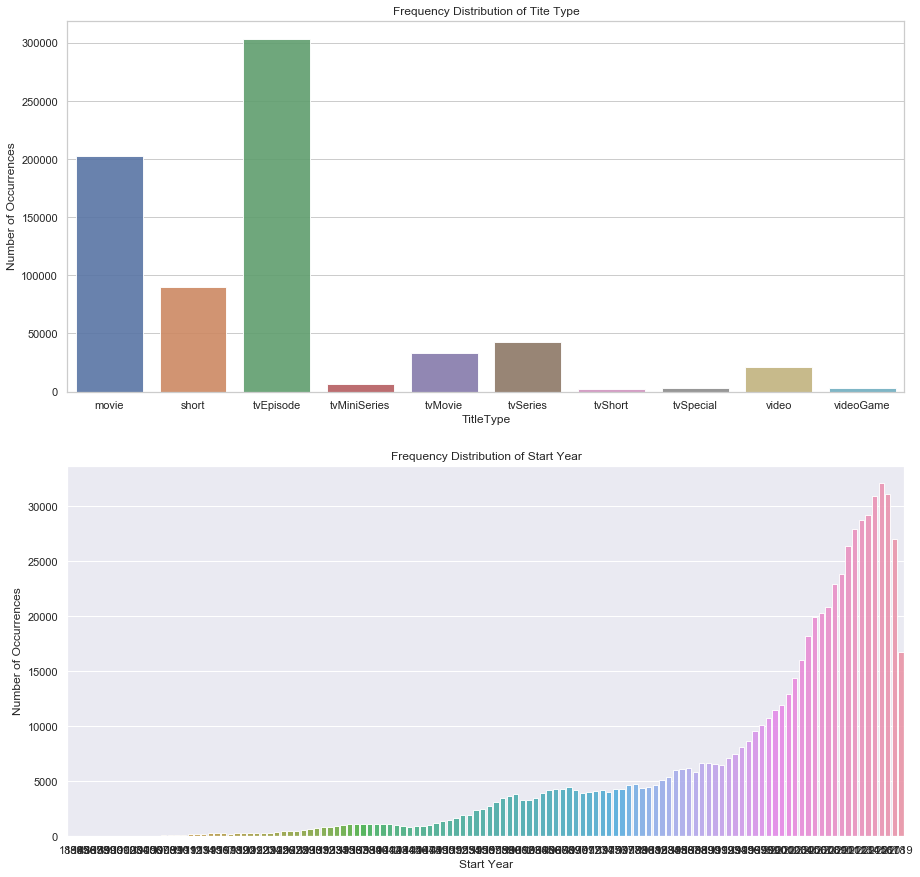

In [40]:
df2.info()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15))


plt.subplot(2, 1, 1)
df2_titleType = df2['titleType'].value_counts()
sns.set(style="darkgrid")
sns.barplot(df2_titleType.index, df2_titleType.values, alpha=0.9)
plt.title('Frequency Distribution of Tite Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('TitleType', fontsize=12)

plt.subplot(2, 1, 2)
df2_startYear = df2['startYear'].value_counts()
sns.set(style="darkgrid")
sns.barplot(df2_startYear.index, df2_startYear.values, alpha=0.9)
plt.title('Frequency Distribution of Start Year')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Start Year', fontsize=12)

#plt.subplot(3, 1, 3)
#df2_runtimeMinutes_q = df2['runtimeMinutes_q'].value_counts()
#sns.set(style="darkgrid")
#sns.barplot(df2_runtimeMinutes_q.index, df2_runtimeMinutes_q.values, alpha=0.9)
#plt.title('Frequency Distribution of Movie Length')
#plt.ylabel('Number of Occurrences', fontsize=12)
#plt.xlabel('Movie Length', fontsize=12)
plt.show()


df2['startYear'] = pd.to_numeric(df2['startYear'])
#df2.drop(df2.index[df2['startYear']  > 1940], inplace = True)
#df2.drop(df2.loc[df2['startYear']  < 2000].index, inplace = True)
print(df2.shape)
print(df2.info())
plt.figure(figsize=(15,15))

plt.subplot(2, 1, 1)
df2_titleType2 = df2['titleType'].value_counts()
sns.set(style="darkgrid")
sns.barplot(df2_titleType2.index, df2_titleType2.values, alpha=0.9)
plt.title('Frequency Distribution of Tite Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('TitleType', fontsize=12)

plt.subplot(2, 1, 2)
df2_startYear2 = df2['startYear'].value_counts()
sns.set(style="darkgrid")
sns.barplot(df2_startYear2.index, df2_startYear2.values, alpha=0.9)
plt.title('Frequency Distribution of Start Year')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Start Year', fontsize=12)

#plt.subplot(3, 1, 3)
#df2_runtimeMinutes_q2 = df2['runtimeMinutes_q'].value_counts()
#sns.set(style="darkgrid")
#sns.barplot(df2_runtimeMinutes_q2.index, df2_runtimeMinutes_q2.values, alpha=0.9)
#plt.title('Frequency Distribution of Movie Length')
#plt.ylabel('Number of Occurrences', fontsize=12)
#plt.xlabel('Movie Length', fontsize=12)
plt.show()

In [41]:
class MultiColumnLabelEncoder:
    
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        http://localhost:8888/notebooks/Google%20Drive/Colab%20Notebooks/COMPSCIX433.1-002/Assingment-2/%5B1%5D%20COMPSCIX433.1-002%20Data%20Science%20Principles%20and%20Practice%20-%20Assignment%202.ipynb#LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        
        output = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [42]:
print(df2.shape)

(709673, 10)


In [43]:
import pickle
df2.to_pickle('my_df.pickle')

# Load Saved Dataframe from Pickle File

In [44]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
!pip install imblearn
from imblearn.over_sampling import SMOTE

dfTemp = pd.read_pickle('my_df.pickle')

In [45]:
dfTemp.head()

,tconst,titleType,isAdult,startYear,genres,numVotes,directors,writers,aRating_eq_bin,averageRating
0,tt0000009,movie,0,1894,[Romance],81,[nm0085156],[nm0085156],1,5.4
1,tt0000036,short,0,1896,"[Drama, Short]",450,[nm0005690],[nm0410331],1,4.5
2,tt0000076,short,0,1896,"[Drama, Short]",393,[nm0005690],[nm0410331],1,4.5
3,tt0000091,short,0,1896,"[Horror, Short]",2495,[nm0617588],[nm0617588],2,6.7
4,tt0000108,short,0,1896,"[Drama, Short]",405,[nm0005690],[nm0410331],1,4.4


In [46]:
dfTemp1 = dfTemp.groupby(["aRating_eq_bin"]).apply(lambda x: x.sort_values(["genres"], ascending = False)).reset_index(drop=True)
# select top N rows within each continent
df2pk = dfTemp1.groupby("aRating_eq_bin").head(10000)
print(df2pk.head())
print(df2pk.shape)

       tconst titleType isAdult  startYear     genres  numVotes    directors  \
0   tt2051886     movie       0       2012  [Western]       125  [nm0478713]   
1  tt10622840     movie       0       2019  [Western]         8  [nm2483722]   
2   tt3125566     movie       0       2013  [Western]        25  [nm5409660]   
3   tt0066287     movie       0       1970  [Western]        23  [nm0951373]   
4   tt0065968     movie       0       1971  [Western]       137  [nm0816807]   

                  writers  aRating_eq_bin  averageRating  
0             [nm0478713]               0            2.8  
1             [nm2483722]               0            2.4  
2             [nm2753792]               0            1.9  
3             [nm0951373]               0            3.2  
4  [nm0754575, nm1343321]               0            3.1  
(30000, 10)


In [47]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

df2pk = df2pk.join(pd.DataFrame(mlb.fit_transform(df2pk.pop('genres')),
                          columns=mlb.classes_,
                          index=df2pk.index))
#df2pkN = df2pkN.join(pd.DataFrame(mlb.fit_transform(df2pkN.pop('genres')),
#                          columns=mlb.classes_,
#                          index=df2pkN.index))

In [48]:
#Due to memory limitation, I am slicing the dtaframe to 20% of the data.
from sklearn.utils import shuffle
df2pk = shuffle(df2pk)
df3 = df2pk.sample(frac=0.10).reset_index(drop=True)
print(df2pk.shape)
print(df3.shape)
print(df3.head())

(30000, 32)
(3000, 32)
      tconst  titleType isAdult  startYear  numVotes    directors  \
0  tt0902281      movie       0       2008       349  [nm0389972]   
1  tt5936796  tvEpisode       0       2016        26  [nm1680829]   
2  tt0529778  tvEpisode       0       1962        53  [nm0568228]   
3  tt0594059  tvEpisode       0       1964       107  [nm0364749]   
4  tt0754307  tvEpisode       0       1959        13  [nm0257638]   

                                             writers  aRating_eq_bin  \
0                                        [nm2308414]               1   
1                                        [nm1680829]               2   
2  [nm0165899, nm0939942, nm0715554, nm0234228, n...               1   
3       [nm0386928, nm0531990, nm0582307, nm0912766]               2   
4                             [nm0344246, nm0480681]               2   

   averageRating  Comedy  ...  News  Reality-TV  Romance  Sci-Fi  Short  \
0            5.0       0  ...     0           0       

In [49]:
import hashlib
X = df3.drop(columns=['startYear', 'tconst','aRating_eq_bin','writers', 'directors', 'numVotes', 'averageRating'])
y = df3['aRating_eq_bin'].copy()

#X_train = df2pkN.drop(columns=['numVotes', 'startYear', 'tconst','aRating_eq_bin','writers', 'directors', 'averageRating'])
#y_train = df2pkN['aRating_eq_bin'].copy()


print(X.info())
print(y.head())

#X_test, X_val, y_test, y_val = train_test_split(
#    X, y, test_size=0.5)


ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
x_remaining, X_test, y_remaining, y_test = train_test_split(
    X, y, test_size=ratio_test)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, y_train, y_val = train_test_split(
    x_remaining, y_remaining, test_size=ratio_val_adjusted)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
titleType      3000 non-null category
isAdult        3000 non-null category
Comedy         3000 non-null int64
Crime          3000 non-null int64
Documentary    3000 non-null int64
Drama          3000 non-null int64
Family         3000 non-null int64
Fantasy        3000 non-null int64
Film-Noir      3000 non-null int64
Game-Show      3000 non-null int64
History        3000 non-null int64
Horror         3000 non-null int64
Music          3000 non-null int64
Musical        3000 non-null int64
Mystery        3000 non-null int64
News           3000 non-null int64
Reality-TV     3000 non-null int64
Romance        3000 non-null int64
Sci-Fi         3000 non-null int64
Short          3000 non-null int64
Sport          3000 non-null int64
Talk-Show      3000 non-null int64
Thriller       3000 non-null int64
War            3000 non-null int64
Western        3000 non-null int64
dtypes: cate

In [50]:
X_train.columns

Index(['titleType', 'isAdult', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western'],
      dtype='object')

In [51]:
X_test.columns

Index(['titleType', 'isAdult', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western'],
      dtype='object')

from sklearn.preprocessing import LabelEncoder
le = MultiColumnLabelEncoder()
X_train_le = le.fit_transform(X_train)
X_test_le = le.fit_transform(X_test)
X_train_le.head()

In [52]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')
print("categories: " , ohe)
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe

categories:  OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)


<2400x57 sparse matrix of type '<class 'numpy.float64'>'
	with 60000 stored elements in Compressed Sparse Row format>

In [53]:
#smote = SMOTE('minority')
#X_sm, y_sm = smote.fit_sample(X_train_ohe, y_train)

In [54]:
X_train_ohe.shape

(2400, 57)

In [55]:
#X_sm.shape

In [56]:
X_test_ohe = ohe.transform(X_test)
print(X_test_ohe)

  (0, 1)	1.0
  (0, 10)	1.0
  (0, 12)	1.0
  (0, 14)	1.0
  (0, 16)	1.0
  (0, 18)	1.0
  (0, 20)	1.0
  (0, 22)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 27)	1.0
  (0, 29)	1.0
  (0, 31)	1.0
  (0, 33)	1.0
  (0, 35)	1.0
  (0, 37)	1.0
  (0, 39)	1.0
  (0, 41)	1.0
  (0, 43)	1.0
  (0, 46)	1.0
  (0, 47)	1.0
  (0, 49)	1.0
  (0, 51)	1.0
  (0, 53)	1.0
  (0, 55)	1.0
  :	:
  (299, 0)	1.0
  (299, 10)	1.0
  (299, 12)	1.0
  (299, 14)	1.0
  (299, 16)	1.0
  (299, 18)	1.0
  (299, 20)	1.0
  (299, 22)	1.0
  (299, 24)	1.0
  (299, 25)	1.0
  (299, 27)	1.0
  (299, 29)	1.0
  (299, 31)	1.0
  (299, 33)	1.0
  (299, 35)	1.0
  (299, 37)	1.0
  (299, 39)	1.0
  (299, 41)	1.0
  (299, 43)	1.0
  (299, 45)	1.0
  (299, 47)	1.0
  (299, 49)	1.0
  (299, 51)	1.0
  (299, 53)	1.0
  (299, 56)	1.0


In [57]:
X_test_ohe.shape

(300, 57)

In [58]:
X_val_ohe = ohe.transform(X_val)
X_val_ohe

<300x57 sparse matrix of type '<class 'numpy.float64'>'
	with 7500 stored elements in Compressed Sparse Row format>

In [59]:
from sklearn.metrics import confusion_matrix
def execute_model(names,classifiers):
    i = 1
    # iterate over datasets
    results = {}
    class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    # preprocess dataset, split into training and test part
    # X_test_ohe
    # X_train_ohe
    # y_train
    # y_test
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        import time        
        cur_time = time.time()
        clf.fit(X_train_ohe, y_train)
        #clf.fit(X_train_ohe, y_train, sample_weight = class_weights)
        training_time = time.time() - cur_time

        cur_time = time.time()
        score = clf.score(X_test_ohe, y_test)
        testing_time = time.time() - cur_time
        
        cur_time = time.time()
        train_accuracy = clf.score(X_train_ohe, y_train)
        scoring = ['precision_macro', 'recall_macro']
        scores = cross_validate(clf, X_val_ohe, y_val, scoring = scoring, cv=2)
        sorted(scores.keys())
        score_time = time.time() - cur_time
        print(name)
        print(scores)
        #print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        results[name] = [training_time, testing_time, score_time, train_accuracy, score]
        i += 1
        print('executing: ' + name)
        dfk = pd.DataFrame.from_dict(
            results, orient='index',
            columns=['Train Time', 'Test Time', 'Cross validation Time','Train Acc', 'Test Acc'])
    display(dfk)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_20newsgroups_vectorized 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.utils import class_weight
h = .02  # step size in the mesh

In [61]:
namesAll = ["RBF SVM", 
            "Linear SVM", 
            "Decision Tree", 
            "Random Forest", 
            "Neural Net", 
            "AdaBoost",
            "Nearest Neighbors"]

classifiersAll = [
    SVC(gamma=1, C=2),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    KNeighborsClassifier(3)]

#QuadraticDiscriminantAnalysis - This one Takes too long to execute and results very low Accuracy so Droppoing it off my list.
names = ["QDA"]
classifiers = [QuadraticDiscriminantAnalysis()]
execute_model(names,classifiers)

#Naive Bayes - This one Takes too long to execute and results very low Accuracy so Droppoing it off my list.
names = ["Naive Bayes"]
classifiers = [GaussianNB()]
execute_model(names,classifiers)

#AdaBoostClassifier
names = ["AdaBoost"]
classifiers = [AdaBoostClassifier()]
execute_model(names,classifiers)

#Neural Net
names = ["Neural Net"]
classifiers = [MLPClassifier(alpha=1, max_iter=1000)]
execute_model(names,classifiers)

#Random Forest
names = ["Random Forest"]
classifiers = [RandomForestClassifier(max_depth=15, n_estimators=25, max_features=78)]
execute_model(names,classifiers)

#Decision Tree
names = ["Decision Tree"]
classifiers = [DecisionTreeClassifier(max_depth=4)]
execute_model(names,classifiers)

#Gaussian Process
names = ["Gaussian Process"]
classifiers = [GaussianProcessClassifier(1.0 * RBF(1.0))]
execute_model(names,classifiers)

In [62]:
import random
#XGBClassifier
#https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
from xgboost import XGBClassifier as xgb
names = ["XGBClassifier"]
xgb_params = {'learning_rate': 0.25, 
              'max_depth': 15,
              'subsample': 0.5,        
              'colsample_bytree': 0.9,
              'objective': 'multi:softprob',
              'silent': 1, 
              'n_estimators':190, 
              'gamma':6,         
              'min_child_weight':8}   

params = {
    "colsample_bytree": random.uniform(0.7, 0.3),
    "gamma": random.uniform(0, 0.5),
    "learning_rate": random.uniform(0.03, 0.3), # default 0.1 
    "max_depth": random.randint(2, 9), # default 3
    "n_estimators": random.randint(75, 150), # default 100
    "subsample": random.uniform(0.6, 0.4)
}

classifiers = [xgb(**xgb_params, seed = 10)]
execute_model(names,classifiers)

XGBClassifier
{'fit_time': array([0.17028666, 0.16216302]), 'score_time': array([0.00548625, 0.00536013]), 'test_precision_macro': array([0.7786141 , 0.66542257]), 'test_recall_macro': array([0.65956072, 0.65175209])}
executing: XGBClassifier


,Train Time,Test Time,Cross validation Time,Train Acc,Test Acc
XGBClassifier,2.926286,0.00648,0.372671,0.855,0.84


#XGBClassifier
#https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
from xgboost import XGBClassifier as xgb
def xgb_model(train_data, train_label, test_data, test_label):
    clf = xgb(max_depth=7,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=500,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)
    clf.fit(train_data, train_label, eval_metric='auc', verbose=True,
            eval_set=[(test_data, test_label)], early_stopping_rounds=100)
    y_pre = clf.predict(test_data)
    y_pro = clf.predict_proba(test_data)[:, 1]
    print("AUC Score : %f" % metrics.roc_auc_score(test_label, y_pro))
    print("Accuracy : %.4g" % metrics.accuracy_score(test_label, y_pre))
    return clf 

xgb_model(X_train_ohe, y_train, X_test_ohe, y_test)

In [63]:
#Executed Multiple models together.
execute_model(namesAll,classifiersAll)

RBF SVM
{'fit_time': array([0.00275207, 0.00229597]), 'score_time': array([0.00379586, 0.00381494]), 'test_precision_macro': array([0.83734183, 0.77101415]), 'test_recall_macro': array([0.83588501, 0.78132567])}
executing: RBF SVM
Linear SVM
{'fit_time': array([0.00409007, 0.00401425]), 'score_time': array([0.00507188, 0.00525784]), 'test_precision_macro': array([0.81024066, 0.74357405]), 'test_recall_macro': array([0.69079457, 0.64450498])}
executing: Linear SVM
Decision Tree
{'fit_time': array([0.0012691 , 0.00123024]), 'score_time': array([0.00205207, 0.00201488]), 'test_precision_macro': array([0.84188034, 0.8028481 ]), 'test_recall_macro': array([0.79134367, 0.74456887])}
executing: Decision Tree
Random Forest
{'fit_time': array([0.01338172, 0.01292324]), 'score_time': array([0.00406814, 0.00403357]), 'test_precision_macro': array([0.73723973, 0.81141081]), 'test_recall_macro': array([0.68349483, 0.77165725])}
executing: Random Forest
Neural Net
{'fit_time': array([1.13999414, 1.1

,Train Time,Test Time,Cross validation Time,Train Acc,Test Acc
RBF SVM,0.148382,0.021493,0.174132,0.867917,0.860000
Linear SVM,0.194168,0.024140,0.207774,0.827083,0.800000
Decision Tree,0.011138,0.000629,0.008905,0.799583,0.750000
Random Forest,0.018276,0.001949,0.040395,0.821667,0.780000
Neural Net,2.624038,0.001763,2.290966,0.860000,0.846667
AdaBoost,0.166597,0.014282,0.259847,0.837500,0.820000
Nearest Neighbors,0.001863,0.073227,0.515022,0.797083,0.786667
